In [1]:
import pandas as pd
import numpy as np

import time
import matplotlib.pyplot as plt



In [6]:
#set path to REMOTES folder
path = '../../../data'

# Load the data
df = pd.read_csv(f'{path}/sensors_data.csv')


import ast

with open(f'{path}/patients_to_remove2.txt') as f:
    lines = f.read()  # Read the entire content
    patients_to_remove = ast.literal_eval(lines)  # Safely evaluate the string as a list

df = df[~df['Patient ID'].isin(patients_to_remove)]

print(len(df))


169


In [8]:
#open the demo_data file 
demo_data = pd.read_csv(f'{path}/demo_data.csv')

#change the column title from study_id to Patient ID
demo_data = demo_data.rename(columns={'study_id': 'Patient ID'})


#merge the demo_data with the WS_data only keeping columns 'cpet_quality', cpet_bike, vo2peak_measured, anaerobic_threshold, bmi, age, gender
df = pd.merge(df, demo_data[['Patient ID', 'cpet_quality', 'cpet_bike', 'vo2peak_measured', 'anaerobicthreshold', 'bmi', 'gender']], on='Patient ID', how='left')


#if cpet_bike is 2, multiply vo2peak_measured by 0.9
df['vo2peak_measured'] = np.where(df['cpet_bike'] == 2, df['vo2peak_measured'] * 0.9, df['vo2peak_measured'])

/Users/aronsyversen/miniforge3/envs/shap_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Fold Test R2 Score: 0.3304
Fold Test MSE: 12.0706
Fold Test MAE: 2.7104
Fold Test R2 Score: 0.4926
Fold Test MSE: 10.6593
Fold Test MAE: 2.4243
Fold Test R2 Score: 0.4708
Fold Test MSE: 12.7139
Fold Test MAE: 2.6609
Fold Test R2 Score: 0.4141
Fold Test MSE: 11.2083
Fold Test MAE: 2.3246
Fold Test R2 Score: 0.7169
Fold Test MSE: 7.4864
Fold Test MAE: 2.2968


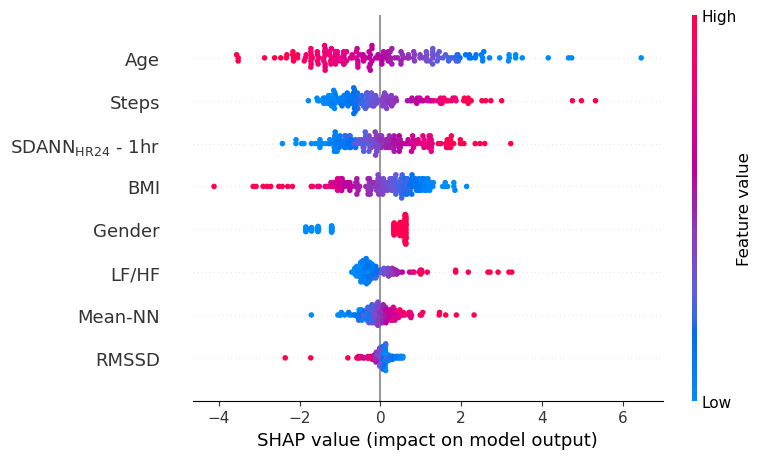

In [9]:
import shap
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Define formatted feature labels
formatted_labels = {
    'age': 'Age',
    'steps': 'Steps',
    'SDNNhr_1hr': r'SDANN$_{\mathrm{HR}24}$ - 1hr',
    'bmi': 'BMI',
    'gender': 'Gender',
    'LF_HF': r'LF/HF',
    'MeanNN': 'Mean-NN',
    'RMSSD': 'RMSSD'
}

# Define X (predictors) and y (target)
features = ['steps', 'age', 'gender', 'bmi', 'SDNNhr_1hr', 'LF_HF', 'MeanNN', 'RMSSD']
X = df[features]
y = df['vo2peak_measured']

# Initialize the KFold cross-validator (5 splits)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize an empty list to store SHAP values and their corresponding test sets
all_shap_values = []
all_test_data = []

# Loop through each fold
for train_index, test_index in kf.split(X):
    # Split the data into training and test sets for this fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Scale the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Initialize and train the model
    model = LinearRegression()
    model.fit(X_train_scaled, y_train)
    
    # Evaluate model performance on the test set (optional)
    y_test_pred = model.predict(X_test_scaled)
    print(f"Fold Test R2 Score: {r2_score(y_test, y_test_pred):.4f}")
    print(f"Fold Test MSE: {mean_squared_error(y_test, y_test_pred):.4f}")
    print(f"Fold Test MAE: {mean_absolute_error(y_test, y_test_pred):.4f}")
    
    # Initialize SHAP explainer
    explainer = shap.LinearExplainer(model, X_train_scaled)  # Use training data to compute baseline
    
    # Calculate SHAP values for the test set
    shap_values = explainer.shap_values(X_test_scaled)
    
    # Save SHAP values and test data
    all_shap_values.append(shap_values)
    all_test_data.append(X_test)

# Concatenate all SHAP values and test data across folds
final_shap_values = np.concatenate(all_shap_values, axis=0)
final_test_data = pd.concat(all_test_data, axis=0)

# Map the features to their formatted labels
updated_labels = [formatted_labels[feature] for feature in features]

# Visualize the SHAP summary plot with updated labels
shap.summary_plot(final_shap_values, final_test_data, feature_names=updated_labels)


Fold Test R2 Score: 0.5123
Fold Test MSE: 7.8932
Fold Test MAE: 2.2689
Fold Test R2 Score: 0.2148
Fold Test MSE: 15.5874
Fold Test MAE: 3.0941
Fold Test R2 Score: 0.5717
Fold Test MSE: 7.6361
Fold Test MAE: 2.1460
Fold Test R2 Score: 0.4086
Fold Test MSE: 13.2849
Fold Test MAE: 2.7305
Fold Test R2 Score: 0.6047
Fold Test MSE: 13.1536
Fold Test MAE: 2.7141
Fold Test R2 Score: -0.0257
Fold Test MSE: 14.2072
Fold Test MAE: 2.8265
Fold Test R2 Score: 0.6344
Fold Test MSE: 5.0994
Fold Test MAE: 1.8509
Fold Test R2 Score: 0.2359
Fold Test MSE: 18.4719
Fold Test MAE: 2.9348
Fold Test R2 Score: 0.6709
Fold Test MSE: 11.1770
Fold Test MAE: 2.9071
Fold Test R2 Score: 0.8132
Fold Test MSE: 3.4335
Fold Test MAE: 1.6110


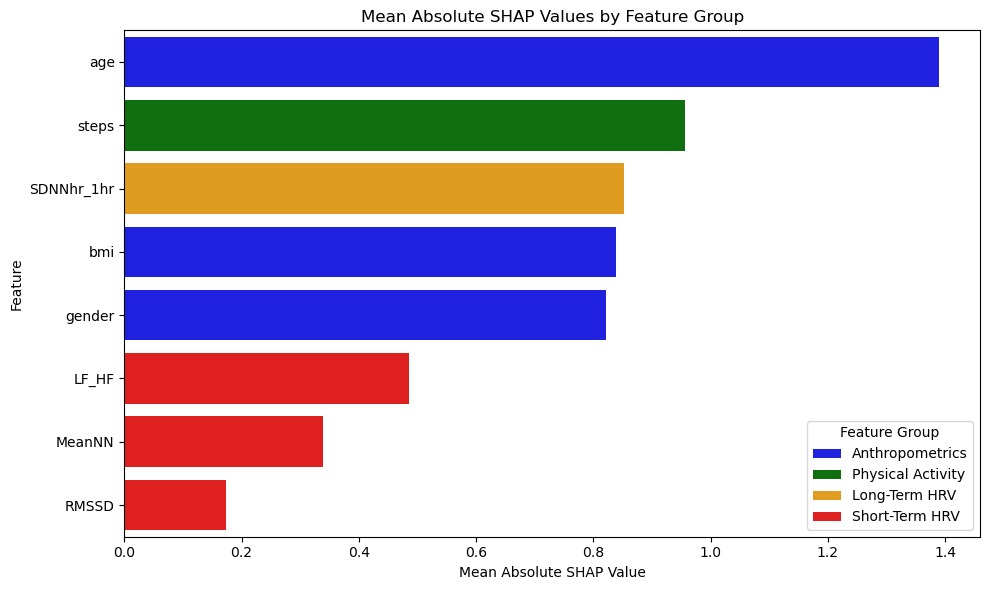

In [13]:
import shap
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Feature group definitions
features = ['steps', 'age', 'gender', 'bmi', 'SDNNhr_1hr', 'LF_HF', 'MeanNN', 'RMSSD']
feature_groups = {
    'Anthropometrics': ['age', 'gender', 'bmi'],
    'Physical Activity': ['steps'],
    'Long-Term HRV': ['SDNNhr_1hr'],
    'Short-Term HRV': ['LF_HF', 'MeanNN', 'RMSSD']
}

# Group colors
group_colors = {
    'Anthropometrics': 'blue',
    'Physical Activity': 'green',
    'Long-Term HRV': 'orange',
    'Short-Term HRV': 'red'
}

# Define X (predictors) and y (target)
X = df[features]
y = df['vo2peak_measured']

# Initialize the KFold cross-validator (5 splits)
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Initialize an empty list to store SHAP values and their corresponding test sets
all_shap_values = []
all_test_data = []

# Loop through each fold
for train_index, test_index in kf.split(X):
    # Split the data into training and test sets for this fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Scale the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Initialize and train the model
    model = LinearRegression()
    model.fit(X_train_scaled, y_train)
    
    # Evaluate model performance on the test set (optional)
    y_test_pred = model.predict(X_test_scaled)
    print(f"Fold Test R2 Score: {r2_score(y_test, y_test_pred):.4f}")
    print(f"Fold Test MSE: {mean_squared_error(y_test, y_test_pred):.4f}")
    print(f"Fold Test MAE: {mean_absolute_error(y_test, y_test_pred):.4f}")
    
    # Initialize SHAP explainer
    explainer = shap.LinearExplainer(model, X_train_scaled)  # Use training data to compute baseline
    
    # Calculate SHAP values for the test set
    shap_values = explainer.shap_values(X_test_scaled)
    
    # Save SHAP values and test data
    all_shap_values.append(shap_values)
    all_test_data.append(X_test)

# Concatenate all SHAP values and test data across folds
final_shap_values = np.concatenate(all_shap_values, axis=0)
final_test_data = pd.concat(all_test_data, axis=0)

# Calculate mean absolute SHAP values for each feature
mean_shap_values = np.abs(final_shap_values).mean(axis=0)

# Create a DataFrame for plotting
shap_df = pd.DataFrame({
    'Feature': features,
    'Mean Absolute SHAP Value': mean_shap_values
})

# Assign feature groups and colors
shap_df['Group'] = shap_df['Feature'].apply(
    lambda x: next((group for group, feat_list in feature_groups.items() if x in feat_list), 'Other')
)
shap_df['Color'] = shap_df['Group'].map(group_colors)

# Sort by SHAP value for better visualization
shap_df = shap_df.sort_values(by='Mean Absolute SHAP Value', ascending=False)

# Plot using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(
    data=shap_df,
    x='Mean Absolute SHAP Value',
    y='Feature',
    hue='Group',
    dodge=False,
    palette=group_colors
)

# Add title, labels, and legend
plt.title("Mean Absolute SHAP Values by Feature Group")
plt.xlabel("Mean Absolute SHAP Value")
plt.ylabel("Feature")
plt.legend(title="Feature Group", loc="best")

# Show the plot
plt.tight_layout()
plt.show()


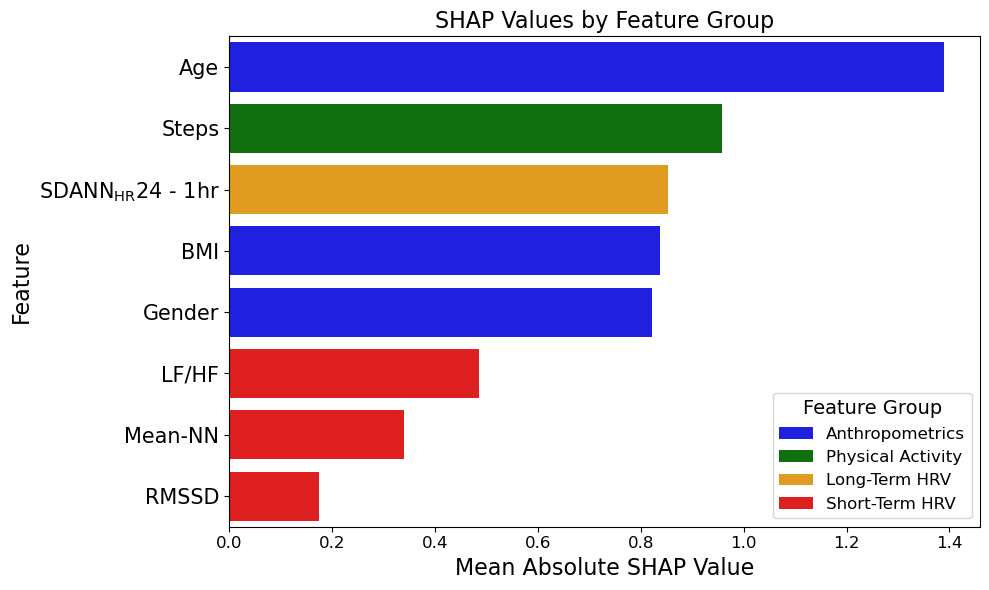

In [14]:
# Map feature names to their formatted labels for the y-axis
formatted_labels = {
    'age': 'Age',
    'steps': 'Steps',
    'SDNNhr_1hr': r'SDANN$_{\mathrm{HR}}$24 - 1hr',
    'bmi': 'BMI',
    'gender': 'Gender',
    'LF_HF': r'LF/HF',
    'MeanNN': 'Mean-NN',
    'RMSSD': 'RMSSD'
}

# Update the DataFrame to include formatted labels
shap_df['Formatted Feature'] = shap_df['Feature'].map(formatted_labels)

# Create the updated Seaborn bar plot with formatted y-axis labels
plt.figure(figsize=(10, 6))
sns.barplot(
    data=shap_df,
    x='Mean Absolute SHAP Value',
    y='Formatted Feature',
    hue='Group',
    dodge=False,
    palette=group_colors
)

# Add title, labels, and legend
plt.title("SHAP Values by Feature Group", fontsize=16)
plt.xlabel("Mean Absolute SHAP Value", fontsize=16)
plt.ylabel("Feature", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=15)
plt.legend(title="Feature Group", loc="best", fontsize=12, title_fontsize=14)

# Show the plot
plt.tight_layout()
plt.show()


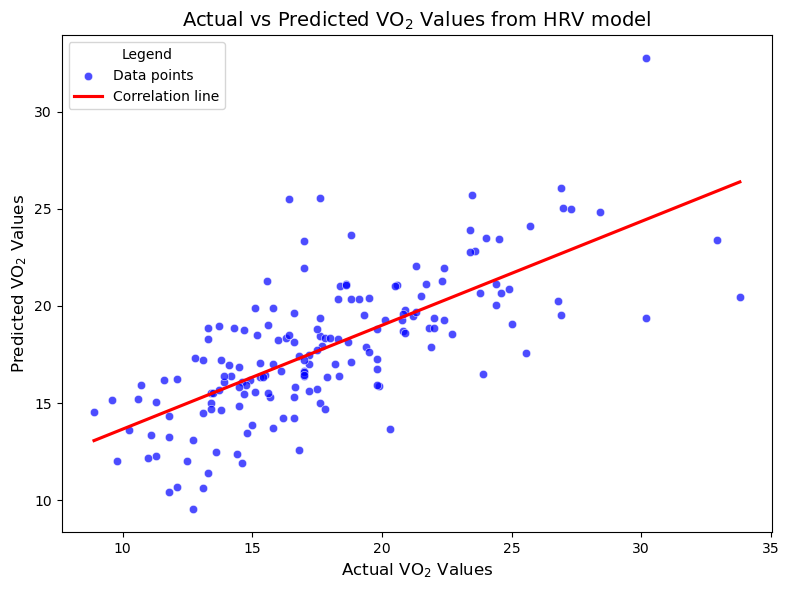

In [15]:
# Assuming predictions and actual values were stored during the KFold process
# Collect all actual and predicted values
all_actuals = []
all_predictions = []

# Loop through each fold to collect predicted and actual values
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Scale the data
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train the model
    model.fit(X_train_scaled, y_train)

    # Predict on the test set
    y_test_pred = model.predict(X_test_scaled)

    # Append to the lists
    all_actuals.extend(y_test)
    all_predictions.extend(y_test_pred)

# Convert to numpy arrays
all_actuals = np.array(all_actuals)
all_predictions = np.array(all_predictions)

# Plot actual vs predicted VO2 values with subscript 2
plt.figure(figsize=(8, 6))
sns.scatterplot(x=all_actuals, y=all_predictions, alpha=0.7, color="blue", label="Data points")

# Add a correlation line without confidence intervals
sns.regplot(x=all_actuals, y=all_predictions, scatter=False, color="red", label="Correlation line", ci=None)

# Add labels, title, and legend with subscript 2 for VO₂
plt.xlabel("Actual VO$_{2}$ Values", fontsize=12)
plt.ylabel("Predicted VO$_{2}$ Values", fontsize=12)
plt.title("Actual vs Predicted VO$_{2}$ Values from HRV model", fontsize=14)
plt.legend(title="Legend", loc="best", fontsize=10)
plt.tight_layout()

# Show the plot
plt.show()

